### Agentic AI - Building an eCommerce Chatbot with tools to query a database


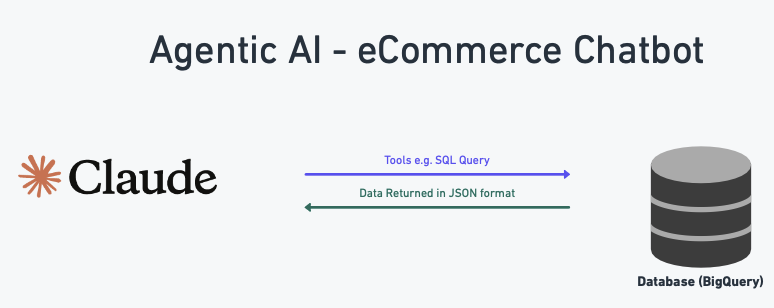 

### Create a Google Cloud Free tier account - https://cloud.google.com/free/docs/free-cloud-features

In [1]:
# Run this command on your terminal and follow the steps to authenticate
# gcloud auth application-default login

In [2]:
#!/usr/bin/env bash

# Enable Vertex AI and BigQuery
# gcloud services enable aiplatform.googleapis.com
# gcloud services enable bigquery.googleapis.com

# Copy public dataset
# bq mk --force=true --dataset ecommerce
# bq mk \
#   --transfer_config \
#   --data_source=cross_region_copy \
#   --target_dataset=thelook_ecommerce \
#   --display_name='Sample Data' \
#   --schedule_end_time="$(date -u -d '5 mins' +%Y-%m-%dT%H:%M:%SZ)" \
#   --params='{
#       "source_project_id":"bigquery-public-data",
#       "source_dataset_id":"thelook_ecommerce",
#       "overwrite_destination_table":"true"
#       }'

### ecommerce database schema
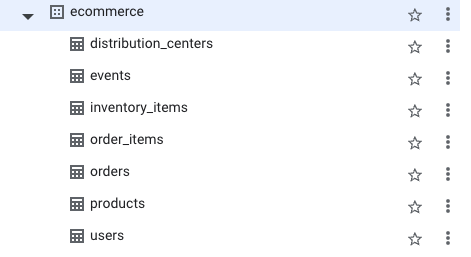

In [3]:
#Load the libraries
from anthropic import Anthropic

In [4]:
# Load environment variables
import os
from dotenv import load_dotenv
_ = load_dotenv()
# os.getenv('ANTHROPIC_API_KEY')

In [5]:
MODEL_NAME="claude-3-5-sonnet-latest"
ant_client = Anthropic()

In [6]:
list_datasets = {
    "name": "list_datasets",
    "description": "Get a list of databases that will help answer the user's question",
    "input_schema": {
        "type": "object",
        "properties": {}
    }
}

list_tables = {
    "name": "list_tables",
    "description": "List tables in a database that will help answer the user's question",
    "input_schema": {
        "type": "object",
        "properties": {
            "database": {
                "type": "string",
                "description": "Database to fetch tables from."
            }
        },
        "required": [
            "dataset_id"
        ]
    }
}

get_table = {
    "name": "get_table",
    "description": "Get information about a table, including the description, schema, and number of rows that will help answer the user's question. Always use the fully qualified table names.",
    "input_schema": {
        "type": "object",
        "properties": {
            "table_id": {
                "type": "string",
                "description": "Fully qualified ID of the table to get information about"
            }
        },
        "required": [
            "table_id"
        ]
    }
}

sql_query = {
    "name": "sql_query",
    "description": "Get information from data in BigQuery using SQL queries",
    "input_schema": {
        "type": "object",
        "properties": {
            "query": {
                "type": "string",
                "description": 
                '''
                SQL query on a single line that will help give quantitative answers to the user's question when run on a BigQuery 
                dataset and table. In the SQL query, always use the fully qualified dataset and table names from the function, 
                which are in the format `project_id.dataset.table name` 
                '''
            }
        },
        "required": [
            "query"
        ]
    }
}
tools = [list_datasets,list_tables, get_table, sql_query]

In [7]:
#check that we can access the data from Google Cloud BigQuery
from google.cloud import bigquery
client = bigquery.Client()
api_response = client.list_tables("ecommerce")
str([table.table_id for table in api_response])

"['distribution_centers', 'events', 'inventory_items', 'order_items', 'orders', 'products', 'users']"

In [8]:
from google.cloud import bigquery
client = bigquery.Client()
PROJECT_ID = os.getenv('GOOGLE_CLOUD_PROJECT')
BIGQUERY_DATASET_ID = "ecommerce"
api_requests_and_responses = []

def process_tool_call(tool_name, tool_input):

    print("tool name", tool_name, "tool_input", tool_input)
    
    if tool_name == "list_datasets":
        datasets = list(client.list_datasets())
        api_response = [dataset.dataset_id for dataset in datasets if dataset.dataset_id == "ecommerce"]
        api_requests_and_responses.append(
            [tool_name, tool_input, api_response]
        )
        return api_response

    if tool_name == "list_tables":
        api_response = client.list_tables(tool_input["database"])
        api_response = str([table.table_id for table in api_response])
        api_requests_and_responses.append(
            [tool_name, tool_input, api_response]
        )
        return api_response

    if tool_name == "get_table":
        table_id = f'{PROJECT_ID}.{BIGQUERY_DATASET_ID}.{tool_input}'
        api_response = client.get_table(table_id)
        api_response = api_response.to_api_repr()
        api_requests_and_responses.append(
            [
                tool_name,
                tool_input,
                [
    str(api_response.get("description", "")),
    str(
        [
            column["name"]
            for column in api_response["schema"]["fields"]
        ]
    ),
                ],
            ]
        )
        
        api_result = [
            column["name"]
            for column in api_response["schema"]["fields"]
        ]
        return api_result

    if tool_name == "sql_query":
        job_config = bigquery.QueryJobConfig(
            maximum_bytes_billed=100000000,
            default_dataset= f"{PROJECT_ID}.{BIGQUERY_DATASET_ID}"
        )  # Data limit per query job
        try:
            cleaned_query = (
                tool_input["query"]
                .replace("\\n", " ")
                .replace("\n", "")
                .replace("\\", "")
            )
            print("cleaned query", cleaned_query)
            query_job = client.query(cleaned_query, project=PROJECT_ID, job_config=job_config)
            api_response = query_job.result()
            api_response = str([dict(row) for row in api_response])
            api_response = api_response.replace("\\", "").replace("\n", "")
            print("API Response", api_response)
            api_requests_and_responses.append(
                [tool_name, tool_input, api_response]
            ) 
        except Exception as e:
            api_response = f"{str(e)}"
            api_requests_and_responses.append(
                [tool_name, tool_input, api_response]
            )
        return api_response

In [9]:
messages = [
    {
        "role": "user",
        "content": "Show me my orders.  My email is cynthiawang@example.net."
    }
]
response = ant_client.messages.create(
    model=MODEL_NAME,
    max_tokens=4096,
    tools=tools,
    messages=messages
)

In [10]:
print(response.content)

[TextBlock(citations=None, text="I'll help you look up orders associated with your email address. Let me first check what datasets and tables are available.", type='text'), ToolUseBlock(id='toolu_01H9xsBcoeFFQkqmYZpPCnTm', input={}, name='list_datasets', type='tool_use')]


In [11]:
print(response.content[-1])

ToolUseBlock(id='toolu_01H9xsBcoeFFQkqmYZpPCnTm', input={}, name='list_datasets', type='tool_use')


In [12]:
tool_use = response.content[-1] 
tool_name = tool_use.name
tool_input = tool_use.input

In [13]:
tool_result = process_tool_call(tool_name, tool_input)
process_tool_call("sql_query", {"query":"SELECT first_name, last_name, id, email, created_at FROM ecommerce.users WHERE email = 'cynthiawang@example.net'"})

tool name list_datasets tool_input {}
tool name sql_query tool_input {'query': "SELECT first_name, last_name, id, email, created_at FROM ecommerce.users WHERE email = 'cynthiawang@example.net'"}
cleaned query SELECT first_name, last_name, id, email, created_at FROM ecommerce.users WHERE email = 'cynthiawang@example.net'
API Response [{'first_name': 'Cynthia', 'last_name': 'Wang', 'id': 12301, 'email': 'cynthiawang@example.net', 'created_at': datetime.datetime(2023, 3, 20, 13, 55, tzinfo=datetime.timezone.utc)}, {'first_name': 'Cynthia', 'last_name': 'Wang', 'id': 1896, 'email': 'cynthiawang@example.net', 'created_at': datetime.datetime(2023, 4, 16, 1, 54, tzinfo=datetime.timezone.utc)}]


"[{'first_name': 'Cynthia', 'last_name': 'Wang', 'id': 12301, 'email': 'cynthiawang@example.net', 'created_at': datetime.datetime(2023, 3, 20, 13, 55, tzinfo=datetime.timezone.utc)}, {'first_name': 'Cynthia', 'last_name': 'Wang', 'id': 1896, 'email': 'cynthiawang@example.net', 'created_at': datetime.datetime(2023, 4, 16, 1, 54, tzinfo=datetime.timezone.utc)}]"

In [14]:
print(tool_name, tool_input)

list_datasets {}


In [15]:
{
    "role": "user",
    "content": [
        {
            "type": "tool_result",
            "tool_use_id": tool_use.id,
            "content": str(tool_result),
        }
    ],
}

{'role': 'user',
 'content': [{'type': 'tool_result',
   'tool_use_id': 'toolu_01H9xsBcoeFFQkqmYZpPCnTm',
   'content': "['ecommerce']"}]}

In [16]:
import re
def extract_reply(text):
    pattern = r'<reply>(.*?)</reply>'
    match = re.search(pattern, text, re.DOTALL)
    if match:
        return match.group(1)
    else:
        return None    
    
def simple_chat():
    system_prompt = """
    You are a customer support chatbot for an online retailer
    called Acme Co.Your job is to help users look up their account and 
    orders, and cancel orders. Be helpful and brief in your responses.
    You have access to a set of tools, but only use them when needed.  
    If you do not have enough information to use a tool correctly, 
    ask a user follow-up questions to get the required inputs.
    Do not call any of the tools unless you have the required 
    data from a user. When calling the sql_query tool, do it with simple joins
    like the one provided below:

    Examples: 
    <examples>
    Customer: Hi, I am trying to fetch my order. Here is my email: heatherjohnson@example.net
    sql_query:
    SELECT oi.*
    FROM `ecommerce.order_items` oi
    JOIN `ecommerce.users` u ON oi.user_id = u.id
    WHERE u.email = 'heatherjohnson@example.net'
    </examples>
    
    In each conversational turn, you will begin by thinking about 
    your response. Once you're done, you will write a user-facing 
    response. It's important to place all user-facing conversational 
    responses in <reply></reply> XML tags to make them easy to parse.
    """
    user_message = input("\nUser: ")
    messages = [{"role": "user", "content": user_message}]
    while True:
        if user_message == "quit":
            break
        #If the last message is from the assistant, 
        # get another input from the user
        if messages[-1].get("role") == "assistant":
            user_message = input("\nUser: ")
            messages.append({"role": "user", "content": user_message})

        #Send a request to Claude
        response = ant_client.messages.create(
            model=MODEL_NAME,
            system=system_prompt,
            max_tokens=4096,
            tools=tools,
            messages=messages
        )
        # Update messages to include Claude's response
        messages.append(
            {"role": "assistant", "content": response.content}
        )

        #If Claude stops because it wants to use a tool:
        if response.stop_reason == "tool_use":
            #Naive approach assumes only 1 tool is called at a time
            tool_use = response.content[-1] 
            tool_name = tool_use.name
            tool_input = tool_use.input
            print(f"=====Claude wants to use the {tool_name} tool=====Input===== {tool_input}")


            #Actually run the underlying tool functionality on our db
            tool_result = process_tool_call(tool_name, tool_input)

            #Add our tool_result message:
            messages.append(
                {
                    "role": "user",
                    "content": [
                        {
                            "type": "tool_result",
                            "tool_use_id": tool_use.id,
                            "content": str(tool_result),
                        }
                    ],
                },
            )
        else: 
            #If Claude does NOT want to use a tool, 
            #just print out the text reponse
            model_reply = extract_reply(response.content[0].text)
            print("\nAcme Co Support: " + f"{model_reply}" )

In [ ]:
simple_chat()
# Please generate a history of my orders, my email is cynthiawang@example.net


User:  tell me about previous order - this is my email stephaniegarcia@example.net


=====Claude wants to use the sql_query tool=====Input===== {'query': "SELECT oi.* FROM `ecommerce.order_items` oi JOIN `ecommerce.users` u ON oi.user_id = u.id WHERE u.email = 'stephaniegarcia@example.net'"}
tool name sql_query tool_input {'query': "SELECT oi.* FROM `ecommerce.order_items` oi JOIN `ecommerce.users` u ON oi.user_id = u.id WHERE u.email = 'stephaniegarcia@example.net'"}
cleaned query SELECT oi.* FROM `ecommerce.order_items` oi JOIN `ecommerce.users` u ON oi.user_id = u.id WHERE u.email = 'stephaniegarcia@example.net'
API Response [{'id': 3848, 'order_id': 2692, 'user_id': 2112, 'product_id': 10586, 'inventory_item_id': 10463, 'status': 'Shipped', 'created_at': datetime.datetime(2022, 11, 8, 12, 11, 25, tzinfo=datetime.timezone.utc), 'shipped_at': datetime.datetime(2022, 11, 9, 14, 49, tzinfo=datetime.timezone.utc), 'delivered_at': None, 'returned_at': None, 'sale_price': 17.75}, {'id': 101510, 'order_id': 70235, 'user_id': 55769, 'product_id': 10659, 'inventory_item_id':


User:  2


=====Claude wants to use the sql_query tool=====Input===== {'query': "SELECT oi.*, p.name as product_name FROM `ecommerce.order_items` oi JOIN `ecommerce.users` u ON oi.user_id = u.id JOIN `ecommerce.products` p ON oi.product_id = p.id WHERE u.email = 'stephaniegarcia@example.net' AND oi.order_id = 70235"}
tool name sql_query tool_input {'query': "SELECT oi.*, p.name as product_name FROM `ecommerce.order_items` oi JOIN `ecommerce.users` u ON oi.user_id = u.id JOIN `ecommerce.products` p ON oi.product_id = p.id WHERE u.email = 'stephaniegarcia@example.net' AND oi.order_id = 70235"}
cleaned query SELECT oi.*, p.name as product_name FROM `ecommerce.order_items` oi JOIN `ecommerce.users` u ON oi.user_id = u.id JOIN `ecommerce.products` p ON oi.product_id = p.id WHERE u.email = 'stephaniegarcia@example.net' AND oi.order_id = 70235
API Response [{'id': 101510, 'order_id': 70235, 'user_id': 55769, 'product_id': 10659, 'inventory_item_id': 274283, 'status': 'Shipped', 'created_at': datetime.da